In [ ]:
%env KAGGLE_USERNAME=matteocasadei
%env KAGGLE_KEY=33d101d14b0da5aa3d36710b8442fee1

In [ ]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

In [ ]:
!gunzip sales_train.csv.gz
!gunzip test.csv.gz
!gunzip sample_submission.csv.gz

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [2]:
def preprocess(dataset=None):
    dataset['date'] =  pd.to_datetime(dataset['date'], format='%d.%m.%Y')
    dataset = dataset.set_index("date")
    dataset = dataset.sort_index()
    return dataset

In [3]:
def reduce_df(dataset=None):
    reduced = dataset.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum()
    reduced = pd.DataFrame({"shop_id": reduced.index.get_level_values(1), "item_id": reduced.index.get_level_values(2), "date_block_num": reduced.index.get_level_values(0), "item_cnt_month": reduced.values}, index=pd.Index(range(reduced.shape[0])))
    return reduced

In [4]:
def generate_stat_features(dataset=None):
    no_items_mnt = dataset.groupby(["shop_id", "date_block_num"])["item_id"].count().reset_index()
    no_sold_item_mnt = dataset.groupby(["shop_id", "date_block_num"])["item_cnt_month"].sum().reset_index()
    stat1 = no_sold_item_mnt.groupby("shop_id")["item_cnt_month"].aggregate(['skew', 'min', 'max', 'mean', 'median', 'std', pd.DataFrame.kurt]).reset_index().add_prefix('shops/').fillna(0)
    q75 = no_sold_item_mnt.groupby("shop_id")["item_cnt_month"].quantile(0.75)
    q25 = no_sold_item_mnt.groupby("shop_id")["item_cnt_month"].quantile(0.25)
    iqr = q75 - q25
    iqr = pd.DataFrame({"iqr": iqr}).fillna(0)
    stat_def = pd.merge(iqr, stat1, left_index=True, right_on="shops/shop_id").drop(columns=["shops/shop_id"])
    no_sold_item_mnt = no_sold_item_mnt.rename(columns={'item_cnt_month': 'tot_items_month'})
    merged = pd.merge(dataset, stat_def, left_on="shop_id", right_index=True)
    merged = pd.merge(merged, no_sold_item_mnt, left_on=["shop_id", "date_block_num"], right_on=["shop_id", "date_block_num"])
    merged["item_perc_month"] = merged.item_cnt_month / merged.tot_items_month
    return merged

In [5]:
def generate_stat_features_items(dataset=None):
    items_mnt = dataset.groupby(["item_id", "date_block_num"])["item_cnt_month"].sum().reset_index()
    items_mnt = items_mnt.rename(columns={"item_cnt_month": "item_tot_sold_month"})
    items_tots = items_mnt.groupby("item_id")["item_tot_sold_month"].sum().reset_index().rename(columns={"item_tot_sold_month": "item_tot_sold"})
    items_stats = items_mnt.groupby("item_id")["item_tot_sold_month"].aggregate(['skew', 'min', 'max', 'mean', 'median', 'std', pd.DataFrame.kurt]).reset_index().add_prefix('items/').fillna(0)
    merged = pd.merge(items_mnt, items_stats, left_on='item_id', right_on='items/item_id').drop(columns=['items/item_id'])
    merged = pd.merge(merged, items_tots, left_on='item_id', right_on='item_id')
    merged = pd.merge(merged, dataset, left_on=["item_id", "date_block_num"], right_on=["item_id", "date_block_num"])
    return merged

In [147]:
def process_dataset(dataset=None):
    sales_train_red = preprocess(dataset=dataset)
    prices = pd.DataFrame({"item_price": dataset['item_price']}, index=dataset.index)
    reduced = reduce_df(dataset=sales_train_red)
    stat1 = generate_stat_features(dataset=reduced)
    stat2 = generate_stat_features_items(dataset=stat1)
    merged = pd.merge(stat2, prices, left_on="item_id", right_index=True)
    y = merged['item_cnt_month']
    merged = merged.drop(columns=['item_cnt_month'])
    return merged.sort_values(by=['date_block_num']), y#.clip(0, 20)

In [163]:
def remove_outliers(dataset=None, target=None, no_items_threshold=np.inf):
    ind = target[target<no_items_threshold].index
    return dataset.loc[ind], target[target<no_items_threshold]   

In [148]:
sales_train = pd.read_csv("sales_train.csv")

In [149]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [150]:
train, y_target = process_dataset(dataset=sales_train)

In [164]:
train, y_target = remove_outliers(dataset=train, target=y_target, no_items_threshold=1000)

In [168]:
train.shape, y_target.shape, y_target.max()

((1609113, 23), (1609113,), 997.0)

In [169]:
train[['date_block_num', 'shop_id', 'item_id', 'item_price']].head()

,date_block_num,shop_id,item_id,item_price
0,20,54,0,999.0
1,15,55,1,899.0
2,18,55,1,899.0
3,19,55,1,899.0
4,20,55,1,899.0


In [170]:
no_shops = sales_train.shop_id.unique().shape[0]
no_items = sales_train.item_id.unique().shape[0]
print("{} shops selling {} items".format(no_shops, no_items))

60 shops selling 21807 items


In [171]:
sales_per_month = sales_train.groupby("date_block_num")["item_cnt_day"].sum()

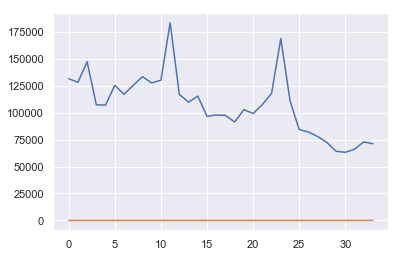

In [172]:
plt.plot(sales_per_month.index.values, sales_per_month.values)
plt.plot(sales_per_month.index.values, np.log(sales_per_month.values))

In [173]:
train.columns

Index(['item_id', 'date_block_num', 'item_tot_sold_month', 'items/skew',
       'items/min', 'items/max', 'items/mean', 'items/median', 'items/std',
       'items/kurt', 'item_tot_sold', 'shop_id', 'iqr', 'shops/skew',
       'shops/min', 'shops/max', 'shops/mean', 'shops/median', 'shops/std',
       'shops/kurt', 'tot_items_month', 'item_perc_month', 'item_price'],
      dtype='object')

In [174]:
num_col = ['date_block_num', 'item_tot_sold_month', 'items/skew',
       'items/min', 'items/max', 'items/mean', 'items/median', 'items/std',
       'items/kurt', 'item_tot_sold', 'iqr', 'shops/skew',
       'shops/min', 'shops/max', 'shops/mean', 'shops/median', 'shops/std',
       'shops/kurt', 'tot_items_month', 'item_perc_month', 'item_price']
cat_col = ['item_id', 'shop_id']

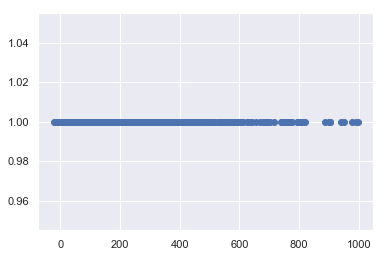

In [175]:
plt.plot(y_target, [1 for _ in range(0, y_target.shape[0])], 'o')

In [176]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import base

In [177]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names, to_array=False):
        self.col_names = col_names  # We will need these in transform()
        self.to_array = to_array
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        if self.to_array:
            return X[self.col_names].values
        else:
            return X[self.col_names]

In [178]:
pipe_cat = Pipeline([
    ("col", ColumnSelectTransformer(cat_col)),
    ("enc", OneHotEncoder())
])

pipe_num = Pipeline([
    ("col", ColumnSelectTransformer(num_col, to_array=True)),
])
union = FeatureUnion([
        ("cat", pipe_cat),
        ("num", pipe_num)
    ])

In [179]:
#test
union.fit_transform(train.iloc[0:10]).todense().shape

/anaconda/envs/jupyter-py3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(10, 27)

In [180]:
train.shape

(1609113, 23)

In [181]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [182]:
rg = RandomForestRegressor()

In [183]:
pipe_def = Pipeline([('union', union), ('reg', rg)])

In [184]:
ts = TimeSeriesSplit(n_splits=3)

In [185]:
grid_search = GridSearchCV(pipe_def, cv=ts, param_grid={'reg__n_estimators': [30], "reg__max_features": [0.5, 0.6, 0.8]}, verbose=3)

In [ ]:
grid_search.fit(train, y_target)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] reg__max_features=0.5, reg__n_estimators=30 .....................


In [186]:
rg = RandomForestRegressor(max_features=0.7, n_estimators=40, n_jobs=-1)
pipe_def = Pipeline([('union', union), ('reg', rg)])

In [187]:
train[train.date_block_num != 33].shape

(1577583, 23)

In [188]:
y_target.loc[train[train.date_block_num != 33].index].shape

(1577583,)

In [189]:
pipe_def.fit(train[train.date_block_num != 33], y_target.loc[train[train.date_block_num != 33].index])

/anaconda/envs/jupyter-py3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('cat', Pipeline(memory=None,
     steps=[('col', ColumnSelectTransformer(col_names=['item_id', 'shop_id'], to_array=False)), ('enc', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, ha...imators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [192]:
y_true = y_target.loc[train[train.date_block_num == 33].index]
y_pred = pipe_def.predict(train[train.date_block_num == 33])

In [193]:
from sklearn.metrics import mean_squared_error
print("Mean squared error {}".format(np.sqrt(mean_squared_error(y_true, y_pred))))

Mean squared error 0.350890167671416


In [194]:
sales_test = pd.read_csv("test.csv")

In [195]:
sales_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [196]:
no_shops = sales_test.shop_id.unique().shape[0]
no_items = sales_test.item_id.unique().shape[0]
print("{} shops selling {} items".format(no_shops, no_items))

42 shops selling 5100 items


In [197]:
sales_test["date_block_num"] = 34

In [198]:
sales_test = pd.merge(sales_test, train[['item_tot_sold_month', 'items/skew',
       'items/min', 'items/max', 'items/mean', 'items/median', 'items/std',
       'items/kurt', 'item_tot_sold', 'iqr', 'shops/skew',
       'shops/min', 'shops/max', 'shops/mean', 'shops/median', 'shops/std',
       'shops/kurt', 'tot_items_month', 'item_perc_month', 'item_price', 'item_id', 'shop_id']], left_on=['item_id', 'shop_id'], right_on=['item_id', 'shop_id'])

In [199]:
sales_test.head()

,ID,shop_id,item_id,date_block_num,item_tot_sold_month,items/skew,items/min,items/max,items/mean,items/median,...,shops/skew,shops/min,shops/max,shops/mean,shops/median,shops/std,shops/kurt,tot_items_month,item_perc_month,item_price
0,0,5,5037,34,209.0,1.199427,25.0,233.0,90.714286,76.0,...,1.549025,877.0,2223.0,1295.818182,1267.0,294.292526,3.331571,1355.0,0.000738,399.0
1,0,5,5037,34,65.0,1.199427,25.0,233.0,90.714286,76.0,...,1.549025,877.0,2223.0,1295.818182,1267.0,294.292526,3.331571,1445.0,0.000692,399.0
2,0,5,5037,34,233.0,1.199427,25.0,233.0,90.714286,76.0,...,1.549025,877.0,2223.0,1295.818182,1267.0,294.292526,3.331571,2127.0,0.000940,399.0
3,0,5,5037,34,108.0,1.199427,25.0,233.0,90.714286,76.0,...,1.549025,877.0,2223.0,1295.818182,1267.0,294.292526,3.331571,1404.0,0.001425,399.0
4,0,5,5037,34,87.0,1.199427,25.0,233.0,90.714286,76.0,...,1.549025,877.0,2223.0,1295.818182,1267.0,294.292526,3.331571,1012.0,0.000988,399.0


In [200]:
y_pred_test = pipe_def.predict(sales_test.drop(columns=['ID']))

In [202]:
y_pred_test[0:214200].shape, y_pred_test[0:214200].max()

((214200,), 960.325)

In [203]:
submit_df = pd.read_csv("sample_submission.csv")

In [204]:
submit_df.shape

(214200, 2)

In [205]:
submit_df['item_cnt_month'] = y_pred_test[0:214200].clip(0, 20)

In [206]:
submit_df.to_csv('submit_new1.csv', index=False)

In [207]:
pipe_def.get_params()['steps'][1][1].feature_importances_.shape

(21412,)